In [1]:
import statsmodels.formula.api as smf
import sklearn
import sklearn.tree
import sklearn.ensemble
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df=pd.read_csv('data/dev/dev-clean-whisper-large-v2-hypotheses.csv')
test_df=pd.read_csv('data/test/test-clean-whisper-large-v2-hypotheses.csv')
# df=pd.read_csv('dev-clean-whisper-large-v2-hypotheses.csv')
# test_df=pd.read_csv('test-clean-whisper-large-v2-hypotheses.csv')
df.head()

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78


In [3]:
df[df["word"] == "."]

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
25110,.,seconds,</s>,3.0,.,NNS,</s>,0.0,4.86,-1.0
27174,.,that,</s>,3.0,.,DT,</s>,0.0,7.01,-1.0
31925,.,that,</s>,3.0,.,IN,</s>,0.0,7.01,-1.0
44175,.,bee,</s>,1.0,.,NN,</s>,0.0,4.09,-1.0
49235,.,are,</s>,3.0,.,VBP,</s>,0.0,6.74,-1.0


Notice how imbalanced the dataset is: there are far more hits than insertions or substitutions.

In [4]:
df['edit_type'].value_counts()

edit_type
0.0    53708
1.0      886
3.0      648
Name: count, dtype: int64

# Data preprocessing
- Represent Part of Speech as one-hot column
- Add feature for word length
- Add feature for word==next/prev_word
- Add Zipf frequencies for start/end of sentence tokens.

There are three "Part of Speech" columns: `word_pos` (for the current word), `prev_word_pos` and `next_word_pos`.
Generate list of all unique parts of speech from across all three columns.

In [5]:
all_pos = set()
pos_cols = [col for col in df.columns if col.endswith('pos')]
for col in pos_cols:
    all_pos.update(df[col].unique())
    all_pos.update(test_df[col].unique())
all_pos = list(all_pos)+['<s>', '</s>']
all_pos.sort()

all_pos

['$',
 '.',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

To use Part of Speech as a feature for training, we need to represent it numerically in some way, since it's a categorical variable.

In [6]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_df.columns.tolist()
df=pd.concat([df, pos_onehot_df], axis=1)
df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82,...,0,1,0,0,0,0,0,0,0,0
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27,...,0,0,0,0,0,0,0,0,0,0
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36,...,0,0,0,0,0,0,0,0,0,0
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36,...,0,0,0,0,0,0,0,0,0,0
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55237,thy,love,knot,1.0,NN,NN,NN,4.11,5.82,3.72,...,0,0,0,0,0,0,0,0,0,0
55238,knot,thy,on,1.0,NN,NN,IN,3.72,4.11,6.91,...,0,0,0,0,0,0,0,0,0,0
55239,on,knot,her,1.0,IN,NN,PRP$,6.91,3.72,6.30,...,0,0,0,0,0,0,0,0,0,0
55240,her,on,more,1.0,PRP,IN,JJR,6.30,6.91,6.36,...,0,0,0,0,0,0,0,0,0,0


Do the same for the test set

In [7]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = test_df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_test_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_test_df.columns.tolist()
test_df=pd.concat([test_df, pos_onehot_test_df], axis=1)
test_df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,concord,<s>,returned,0.0,NN,<s>,VBN,3.47,-1.00,4.82,...,0,0,0,1,0,0,0,0,0,0
1,returned,concord,to,0.0,VBD,NN,TO,4.82,3.47,7.43,...,0,0,0,0,0,0,0,0,0,0
2,to,returned,its,0.0,TO,VBD,PRP$,7.43,4.82,6.14,...,0,0,0,0,0,0,0,0,0,0
3,its,to,place,0.0,PRP$,TO,NN,6.14,7.43,5.71,...,0,0,0,0,0,0,0,0,0,0
4,place,its,amidst,0.0,NN,PRP$,IN,5.71,6.14,3.56,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54455,him,in,thy,0.0,PRP,IN,JJ,6.11,7.27,4.11,...,0,0,0,0,0,0,0,0,0,0
54456,thy,him,fair,0.0,JJ,PRP,JJ,4.11,6.11,4.99,...,0,0,0,0,0,0,0,0,0,0
54457,fair,thy,appearance,0.0,JJ,JJ,NN,4.99,4.11,4.69,...,0,0,0,0,0,0,0,0,0,0
54458,appearance,fair,lies,0.0,NN,JJ,VBZ,4.69,4.99,4.73,...,0,0,0,0,0,1,0,0,0,0


Add feature for whether current word is the same as the previous or following word.
This is useful since Whisper often ``hallucinates'' repeated instances of a word that aren't present in the actual audio.

In [8]:
for df in [df, test_df]:
    df['prev_word_same']=(df['word']==df['prev_word']).astype(int)
    df['next_word_same']=(df['word']==df['next_word']).astype(int)
word_equal_cols = ['prev_word_same', 'next_word_same']
df[word_equal_cols].value_counts()

prev_word_same  next_word_same
0               0                 54207
1               1                   195
0               1                    29
1               0                    29
Name: count, dtype: int64

Start/end token frequencies are set to "-1" by default, since they don't have Zipf frequencies in the `wordfreq` package given that they aren't real words. This is not ideal, since it doesn't accurately reflect how often sentence edges occur. However, we can estimate sentence token frequencies within the LibriSpeech corpus by treating them as words that each occur once per sentence.

In [9]:
freq_cols = [col for col in df.columns if col.endswith('freq')]
df[freq_cols]

,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,3.47,-1.00,4.82
1,4.82,3.47,7.43
2,7.43,4.82,6.14
3,6.14,7.43,5.71
4,5.71,6.14,3.56
...,...,...,...
54455,6.11,7.27,4.11
54456,4.11,6.11,4.99
54457,4.99,4.11,4.69
54458,4.69,4.99,4.73


In [10]:
num_words = len(df)
num_sent = df['prev_word_pos_is_<s>'].value_counts()[1]
sent_token_freq=num_sent/num_words
sent_token_per_bill=sent_token_freq*10**9
sent_token_zipf_freq = np.log10(sent_token_per_bill)
for col in freq_cols:
    df.loc[df[col]==-1, col]=sent_token_zipf_freq
    test_df.loc[test_df[col]==-1, col]=sent_token_zipf_freq

Let's also add word length as a feature, since (presumably) longer words will be harder for the ASR model to predict correctly.

In [11]:
word_cols = [col for col in df.columns if col.endswith('word')]
wordlen_cols = []
for col in word_cols:
    wordlen_col=col+'_len'
    df[wordlen_col]=df[col].str.len()
    test_df[wordlen_col]=test_df[col].str.len()
    wordlen_cols.append(wordlen_col)
df[wordlen_cols]

,word_len,prev_word_len,next_word_len
0,7,3,8
1,8,7,2
2,2,8,3
3,3,2,5
4,5,3,6
...,...,...,...
54455,3,2,3
54456,3,3,4
54457,4,3,10
54458,10,4,4


# Visualization

In [12]:
# 原始行数
original_len = len(df)

# 过滤掉 word_pos == "."
df = df[df["word_pos"] != "."]

# 新的行数
new_len = len(df)

# 计算 drop 掉的行数
dropped_rows = original_len - new_len
print("Dropped rows with word_pos == '.':", dropped_rows)


Dropped rows with word_pos == '.': 5


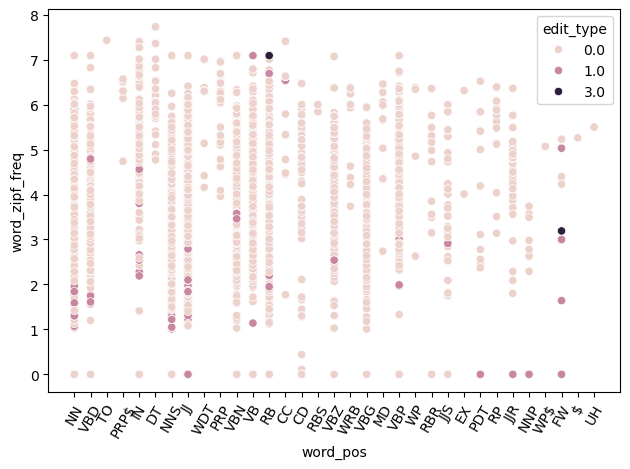

In [13]:
sns.scatterplot(
    data=df,
    x='word_pos',
    y='word_zipf_freq',
    hue='edit_type',
)

plt.xticks(rotation=60)
plt.tight_layout()

plt.show()

In [14]:
print("word_pos 种类：", df['word_pos'].unique())

word_pos 种类： ['NN' 'VBD' 'TO' 'PRP$' 'IN' 'DT' 'NNS' 'JJ' 'WDT' 'PRP' 'VBN' 'VB' 'RB'
 'CC' 'CD' 'RBS' 'VBZ' 'WRB' 'VBG' 'MD' 'VBP' 'WP' 'RBR' 'JJS' 'EX' 'PDT'
 'RP' 'JJR' 'NNP' 'WP$' 'FW' '$' 'UH']


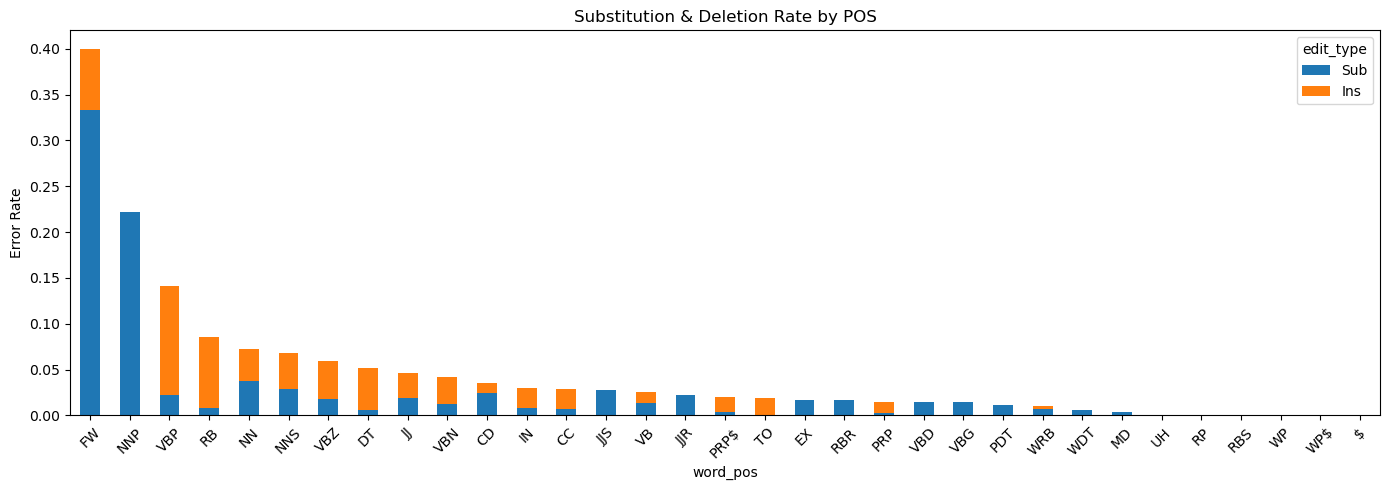

In [15]:
# fault rate of each POS
pos_error_rate = (
    df.groupby("word_pos")["edit_type"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .rename(columns={0.0: "Hit", 1.0: "Sub", 3.0: "Ins"})
)

# 加总错误率列再排序
pos_error_rate["ErrorRate"] = pos_error_rate["Sub"] + pos_error_rate["Ins"]
pos_error_rate = pos_error_rate.sort_values("ErrorRate", ascending=False)

# 可视化
pos_error_rate[["Sub", "Ins"]].plot(kind="bar", stacked=True, figsize=(14, 5))
plt.title("Substitution & Deletion Rate by POS")
plt.ylabel("Error Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_508/2483105004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zipf_bin'] = pd.cut(df['word_zipf_freq'], bins=[0, 2, 4, 6, 8], labels=["0-2", "2-4", "4-6", "6-8"])
/tmp/ipykernel_508/2483105004.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["word_pos", "zipf_bin"])


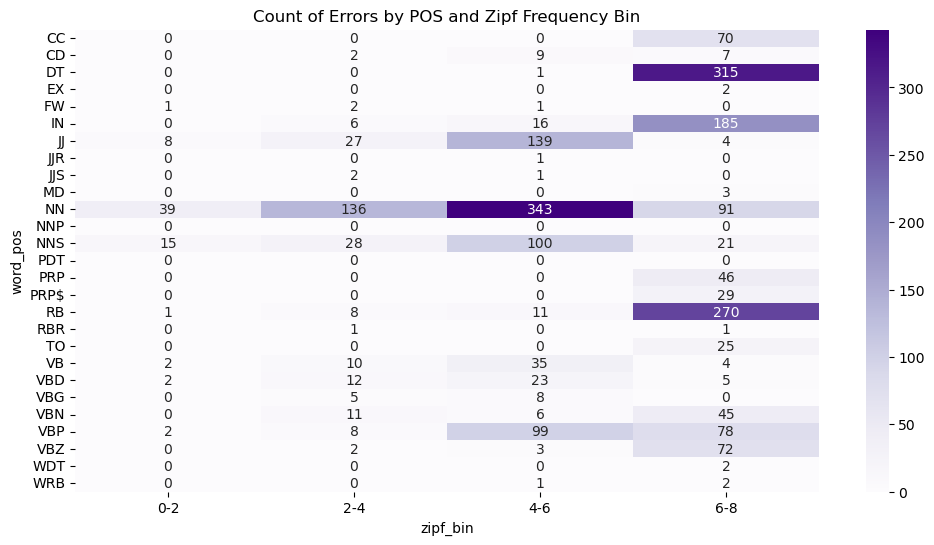

In [16]:
df['zipf_bin'] = pd.cut(df['word_zipf_freq'], bins=[0, 2, 4, 6, 8], labels=["0-2", "2-4", "4-6", "6-8"])

heatmap_data = (
    df[df['edit_type'] != 0]
    .groupby(["word_pos", "zipf_bin"])
    .size()
    .unstack()
    .fillna(0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Purples", annot=True, fmt=".0f")
plt.title("Count of Errors by POS and Zipf Frequency Bin")
plt.show()


# Model fitting

In [17]:
df.head()

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB,prev_word_same,next_word_same,word_len,prev_word_len,next_word_len,zipf_bin
0,concord,<s>,returned,0.0,NN,<s>,VBN,3.47,7.682224,4.82,...,0,0,0,0,0,0,7,3,8,2-4
1,returned,concord,to,0.0,VBD,NN,TO,4.82,3.470000,7.43,...,0,0,0,0,0,0,8,7,2,4-6
2,to,returned,its,0.0,TO,VBD,PRP$,7.43,4.820000,6.14,...,0,0,0,0,0,0,2,8,3,6-8
3,its,to,place,0.0,PRP$,TO,NN,6.14,7.430000,5.71,...,0,0,0,0,0,0,3,2,5,6-8
4,place,its,amidst,0.0,NN,PRP$,IN,5.71,6.140000,3.56,...,0,0,0,0,0,0,5,3,6,4-6


In [43]:
class_weight = 1-df['edit_type'].value_counts()/len(df)
class_weight=dict(class_weight)

X = df[wordlen_cols+word_equal_cols+pos_onehot_cols]
y = df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error
tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=40, class_weight=class_weight)
rf_clf = sklearn.ensemble.RandomForestClassifier(max_depth=40, class_weight=class_weight) #increase max_depth of rf from 10 to 30
tree_clf.fit(X, y)
rf_clf.fit(X, y)

RandomForestClassifier(class_weight={0.0: 0.0469745661555413,
                                     1.0: 0.983968414287026,
                                     3.0: 0.9690570195574327},
                       max_depth=40)

# Score Decision Tree

In [24]:
X_test = test_df[wordlen_cols+word_equal_cols+pos_onehot_cols]
y_test = test_df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error
y_hat = tree_clf.predict(X_test)
sklearn.metrics.confusion_matrix(y_test, y_hat)

array([[49821,  1185,   891],
       [   26,   843,     5],
       [    8,     6,  1675]])

In [20]:
sklearn.metrics.f1_score(y_test, y_hat, average=None)

array([0.97934396, 0.58109041, 0.78638498])

# Score Random Forest

In [41]:
X_test = test_df[wordlen_cols+word_equal_cols+pos_onehot_cols]
y_test = test_df['edit_type']#.map({0:0, 1:1, 3:1}) # uncomment for binary classification, i.e. hit vs any error
y_hat = rf_clf.predict(X_test)
sklearn.metrics.confusion_matrix(y_test, y_hat)

array([[50567,   599,   731],
       [   72,   794,     8],
       [   24,     1,  1664]])

In [42]:
sklearn.metrics.f1_score(y_test, y_hat, average=None)

array([0.98609594, 0.70017637, 0.81329423])